# Awareness Modeling Using Matrix Factorization : LDA


In [1]:
%matplotlib inline
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial
from pygsp import graphs, filters, plotting
from sklearn.decomposition import NMF, LatentDirichletAllocation
import json
import tqdm as tqdm

Import all the features (created in the SVR notebook)

In [2]:
features_df = pd.read_pickle("all_features_pos.pickle")

## Applying the LDA to the Standardized Features

Taking the standardized and positive feature vector we compute the Matrix factorization to extract the countries / topics matrix. 

(247, 186)


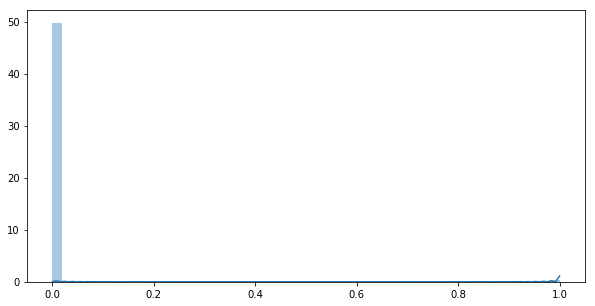

In [3]:
features_mat = features_df.as_matrix()

n_samples = np.shape(features_mat)[1]
n_features = len(features_df.columns)
n_components = round(np.shape(features_mat)[1]/8)

W = LatentDirichletAllocation(n_components=n_components, max_iter=20,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0).fit_transform(features_mat)

pkl_file = open("LDA_weights.pickle", 'wb')
pickle.dump(W,pkl_file)
pkl_file.close()

print(np.shape(W))
plt.figure(figsize=[10,5])
sns.distplot(W.flatten())

## Weight Matrix and Graph

Given the matrix W we can compute the distance between the different vectors and use that as the weights for the edges in our graph. 

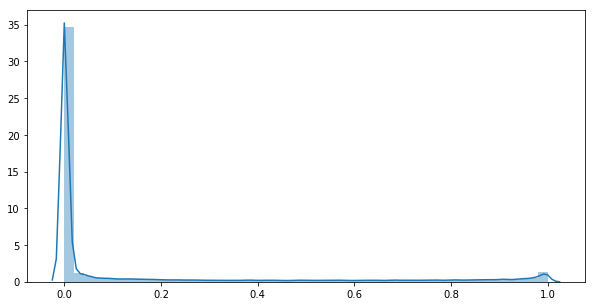

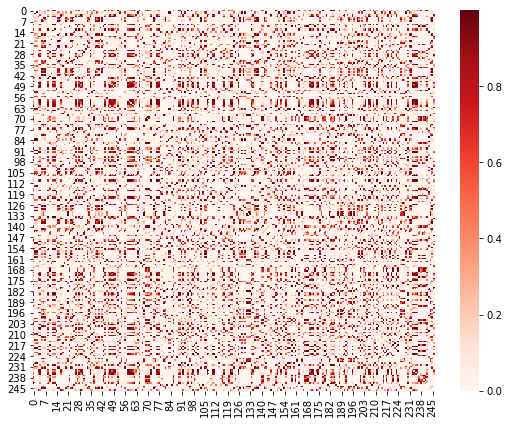

In [4]:
W = pickle.load(open('LDA_weights.pickle','rb'))
distances = spatial.distance.squareform(spatial.distance.pdist(W)) # W
#plt.figure(figsize=[9,7])
#sns.heatmap(distances)

kernel_width = np.mean(distances)- np.std(distances)#distances.mean()

def kernel(x):
    return np.exp(- np.power(x/kernel_width,2))

# applying the kernel to the distances matrix :
weights = kernel(distances)
# setting the diagonal (self-loops) weights to 0 :
weights[range(len(weights)),range(len(weights))] = 0

# displaying a subset of the weights matrix :

plt.figure(figsize=[10,5])
sns.distplot(weights.flatten())
plt.figure(figsize=[9,7])
sns.heatmap(weights,cmap="Reds")

In [5]:
# Get the position of the nodes
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
c_data.drop("United States Minor Outlying Islands",inplace = True)

countries = c_data.index.tolist()

weights_df = pd.DataFrame(weights,columns=countries,index=countries)
weights_df.head()

,Aruba,Afghanistan,Angola,Anguilla,Åland Islands,Albania,Andorra,United Arab Emirates,Argentina,Armenia,...,British Virgin Islands,United States Virgin Islands,Vietnam,Vanuatu,Wallis and Futuna,Samoa,Yemen,South Africa,Zambia,Zimbabwe
Aruba,0.000000e+00,2.556244e-07,9.565774e-07,0.055319,0.310281,1.417958e-12,1.085879e-14,1.852810e-11,5.262517e-26,0.725116,...,2.146913e-01,8.536923e-01,4.615083e-02,2.685299e-01,5.707762e-01,9.803327e-01,5.103174e-06,3.642279e-17,2.366975e-12,0.022656
Afghanistan,2.556244e-07,0.000000e+00,9.704453e-01,0.008092,0.000363,1.718379e-01,4.292622e-02,3.148643e-01,2.043417e-58,0.000015,...,3.481966e-12,9.839280e-09,1.369977e-14,9.041286e-12,4.265030e-10,7.514870e-07,2.005517e-24,6.153960e-03,1.953765e-01,0.022316
Angola,9.565774e-07,9.704453e-01,0.000000e+00,0.016797,0.000935,1.053015e-01,2.252963e-02,2.105559e-01,1.074648e-56,0.000047,...,2.002403e-11,4.225874e-08,9.412003e-14,5.033320e-11,2.068705e-09,2.678157e-06,2.514870e-23,2.733286e-03,1.217873e-01,0.042555
Anguilla,5.531909e-02,8.092259e-03,1.679680e-02,0.000000,0.681222,4.104924e-06,1.439920e-07,2.274625e-05,1.547259e-38,0.276122,...,1.744484e-04,1.220184e-02,6.535874e-06,3.001743e-04,2.470127e-03,8.760385e-02,1.959160e-12,2.489387e-09,5.794373e-06,0.941860
Åland Islands,3.102815e-01,3.632942e-04,9.346011e-04,0.681222,0.000000,3.558853e-08,7.172385e-10,2.695180e-07,1.107088e-33,0.767152,...,4.550547e-03,1.120321e-01,3.221067e-04,6.971455e-03,3.504199e-02,4.126277e-01,8.308633e-10,6.824578e-12,5.339897e-08,0.473768


Checking to see the closest countries to Germany to see if the output is coherent

In [6]:
country = 'Germany'
weights_df[country].loc[weights_df[country] >= 0.9].sort_values(ascending = False)

Micronesia                          0.999975
French Guiana                       0.998474
Jamaica                             0.997843
Suriname                            0.997570
Iraq                                0.997164
Cook Islands                        0.991718
Uzbekistan                          0.989035
Oman                                0.988879
Åland Islands                       0.979498
South Korea                         0.978334
Tajikistan                          0.977493
Saint Vincent and the Grenadines    0.977463
Indonesia                           0.976148
Croatia                             0.975970
Vatican City                        0.974925
Italy                               0.971886
Svalbard and Jan Mayen              0.966819
Liberia                             0.966378
Fiji                                0.962212
Djibouti                            0.961730
Trinidad and Tobago                 0.958580
Northern Mariana Islands            0.953244
Sint Maart

Here we can already note quite a few incoherences as it is highly unlikely that an event in Germany would generate equal reactions in over 100 countries. 

## Creating the Graph And Use Heat Diffusion On The Graph To Estimate Levels Of Reaction

Nonetheless we use the graph diffusion to have a better visualization of the spread of reactions which we will then be able to see on the tweet-awareness.eu website

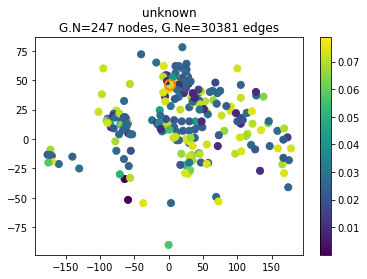

In [7]:

# Get the position of the nodes
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
c_data.drop("United States Minor Outlying Islands",inplace = True)
countries = c_data.index.tolist()


weights_df = pd.DataFrame(weights,columns=countries,index=c_data.index.tolist())

country_pos = np.array(c_data[['latlng']].as_matrix())
country_pos = [ np.array(x[0]) for x in country_pos]
country_pos = np.vstack(country_pos)
country_pos = np.transpose(np.vstack((country_pos[:,1], country_pos[:,0])))

# Create the graph
G = graphs.Graph(weights_df.as_matrix())

G.set_coordinates(country_pos)
G.compute_fourier_basis()

# Create the heat diffusion filter
filt = filters.Heat(G, tau=100)


# Create the signal for a given country
for NODE, country in enumerate(weights_df.index):
    
    signal = np.zeros(G.N)
    signal[NODE] = 10

    # Apply the filter to the signal
    filtered_s = filt.filter(signal)
    
   
    if NODE > 0:
        filtered_signals = np.vstack((filtered_signals, filtered_s))
    else : 
        filtered_signals = filtered_s
    
    if country == "France":
        # Plot the signal on the graph
        G.plot_signal(filtered_s, vertex_size=50, highlight=NODE)

filtered_signals = np.transpose(filtered_signals)


Here we can see more clearly what is going on (with the dots placed at the center of each country). There does not seem to be any logic to the madness... To visualize this more clearly please refer to the interactive plot on the data-story.

## Exporting the results to a json which can be visualized on a map

In [8]:
diffusion_json = {}

country_names = c_data.ISO3.tolist()

diffusion_df = pd.DataFrame(filtered_signals, columns = country_names, index = country_names)

graph_diffusion_json = diffusion_df.to_json(force_ascii=False,orient='columns')


diffusion_json['graph_diffusion'] = dict(json.loads(graph_diffusion_json))

story_path = '../../../Data-Story/'
metrics_file = open(os.path.join(story_path,'III-Analysis','diffusion.json'), 'w')

json.dump(diffusion_json,metrics_file,separators=(',', ':'), indent=4)
metrics_file.close()
